# Run MCMC sampling

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from exp_analysis_class import exp_analysis, ctau_heavy, points_on_triangle
from dark_nus_utils import load_datasets

In [3]:
from Likelihood import LEff
import emcee
import corner
from multiprocessing import Pool

In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [5]:
save_folder = '../fig/5_mcmc/'
!mkdir -p $save_folder

my_exp_analyses = load_datasets('heavy', 'majorana', timeit=True, direct_load_objects=True)

general_smoothing_pars = (0.005, 0.05)

/bin/bash: port_used: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_port_used'
/bin/bash: wait_until_port_used: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_wait_until_port_used'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_module'
/bin/bash: find_port: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_find_port'
/bin/bash: random_number: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_random_number'
/bin/bash: helmod: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_helmod'
/bin/bash: source_helpers: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_source_h

In [6]:
my_exp_analyses = load_datasets('heavy', 'majorana', timeit=True, direct_load_objects=True)

heavy majorana
Wall time: 0.5449314117431641 s, CPU time: 0.5435832370000004


In [7]:
case = 'heavy_majorana'
this_exp_analysis = my_exp_analyses[case]
selection_step = 'cut_based'
this_df_base = my_exp_analyses[case].df_base.query(selection_step)
interaction_point = [this_df_base['int_point_x'],
                     this_df_base['int_point_y'],
                     this_df_base['int_point_z']]
decay_length = [this_df_base['unitary_decay_length_x'],
                this_df_base['unitary_decay_length_y'],
                this_df_base['unitary_decay_length_z']]

this_Vmu4_alpha_epsilon2 = this_exp_analysis.Vmu4_alpha_epsilon2
this_D_or_M = this_exp_analysis.D_or_M

general_smoothing_pars = (0.005, 0.05)

observed_events = 0

In [85]:
this_exp_analysis.upper_bound_Vmu4_alpha_epsilon2_minimal = 6.5e-7
this_exp_analysis.upper_bound_mu_minimal = this_exp_analysis.upper_bound_Vmu4_alpha_epsilon2_minimal / this_exp_analysis.Vmu4_alpha_epsilon2

In [86]:
this_exp_analysis.upper_bound_mu_minimal

2199851.7786561265

In [89]:
def heavy_minimal_posterior_global(parameters):
    '''Posterior in the minimal model: parameters = [m4, mz, mu_Vmu4_alpha_epsilon2]
       It uses global pars to speed up parallel computation'''
    if (parameters[0] < this_exp_analysis.m4_limits[0]) or\
       (parameters[0] > this_exp_analysis.m4_limits[1]) or\
       (parameters[1] < this_exp_analysis.mz_limits[0]) or\
       (parameters[1] > this_exp_analysis.mz_limits[1] or\
       (parameters[0] >= parameters[1])) or\
       (parameters[2] <= 0) or\
       (parameters[2] > this_exp_analysis.upper_bound_mu_minimal):
        return -np.inf
    else:
        actual_Vmu4_alpha_epsilon2 = this_Vmu4_alpha_epsilon2 * parameters[2]
        ctau = ctau_heavy(parameters[0], 
                          parameters[1], 
                          actual_Vmu4_alpha_epsilon2, 
                          this_D_or_M)
        mu, sigma2 = this_exp_analysis.kde_n_events_fast(df=this_df_base,
                                                         m4mz=(parameters[0], parameters[1]),
                                                         ctau=ctau,
                                                         int_point=interaction_point,
                                                         decay_length=decay_length,
                                                         mu=parameters[2],
                                                         smoothing=general_smoothing_pars)
        return LEff(observed_events, mu, sigma2)

In [90]:
nwalkers = 9
ndim = 3
nstep_burn_in = 12000
nstep_sampling = 4000
m4_mz_0 = points_on_triangle(nwalkers, 
                             this_exp_analysis.m4_limits, 
                             this_exp_analysis.mz_limits, 
                             this_exp_analysis.hierarchy)
mu_Vmu4_alpha_epsilon2_0 = np.random.uniform(0, this_exp_analysis.upper_bound_mu_minimal, nwalkers)
p0 = np.column_stack([m4_mz_0, mu_Vmu4_alpha_epsilon2_0])

In [95]:
for i in range(nwalkers):
    print(p0[i], heavy_minimal_posterior_global(p0[i]))

[1.56827208e-02 2.59566664e-01 1.41507823e+06] -27582.851104456815
[3.06320686e-01 9.77620533e+00 1.02008817e+06] -0.6903665812236174
[5.36827248e-02 2.62591834e+00 1.24787521e+06] -3.549855867544952
[4.29330308e-01 8.03666889e+00 1.55756193e+06] -0.6931538413858306
[6.71807164e-01 7.17090118e+00 1.06764087e+06] 0
[9.66391031e-02 8.16685547e+00 3.16313924e+05] -0.6934317409751051
[3.04015801e-01 5.65307868e+00 2.18364037e+06] 0
[6.84730055e-01 7.57865961e+00 1.31409868e+05] 0
[1.12176465e-01 7.15846042e+00 1.32874720e+06] -0.6855051333234468


In [96]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, heavy_minimal_posterior_global, pool=pool)
    state = sampler.run_mcmc(p0, nstep_burn_in, progress=True)
    sampler.reset()
    sampler.run_mcmc(state, nstep_sampling, progress=True)
    
samples = sampler.get_chain(flat=True)
np.save('mcmc_heavy_minimal.npy', samples)

100%|██████████| 4000/4000 [03:16<00:00, 20.35it/s]


In [99]:
likelihood_values = []
for sample in samples:
    likelihood_values.append(heavy_minimal_posterior_global(sample))

In [100]:
new_samples = samples.copy()
new_samples = np.concatenate([new_samples, (np.asarray(likelihood_values))[...,np.newaxis]], axis=1)

In [101]:
new_samples

array([[ 5.08852224e-01,  4.18671848e+00,  1.02395846e+06,
         0.00000000e+00],
       [ 2.00573958e-01,  9.44659815e+00,  4.11993029e+05,
        -6.94276672e-01],
       [ 9.56069698e-01,  7.17400371e+00,  1.61630554e+06,
         0.00000000e+00],
       ...,
       [ 6.01661451e-01,  7.12388820e-01,  2.39602686e+05,
         0.00000000e+00],
       [ 3.87853206e-01,  1.08886772e+00,  1.41790291e+06,
         0.00000000e+00],
       [ 5.46218541e-01,  2.50805476e+00,  1.54092193e+05,
         0.00000000e+00]])

In [97]:
physics_samples = samples.copy()
physics_samples[:, 2] *= this_Vmu4_alpha_epsilon2
ctau_fit = ctau_heavy(physics_samples[:, 0],
                      physics_samples[:, 1],
                      physics_samples[:, 2],
                      this_D_or_M)
physics_samples = np.concatenate([physics_samples, ctau_fit[...,np.newaxis]], axis=1)
physics_samples[:, 2] = np.log10(physics_samples[:, 2])
physics_samples[:, 3] = np.log10(physics_samples[:, 3])

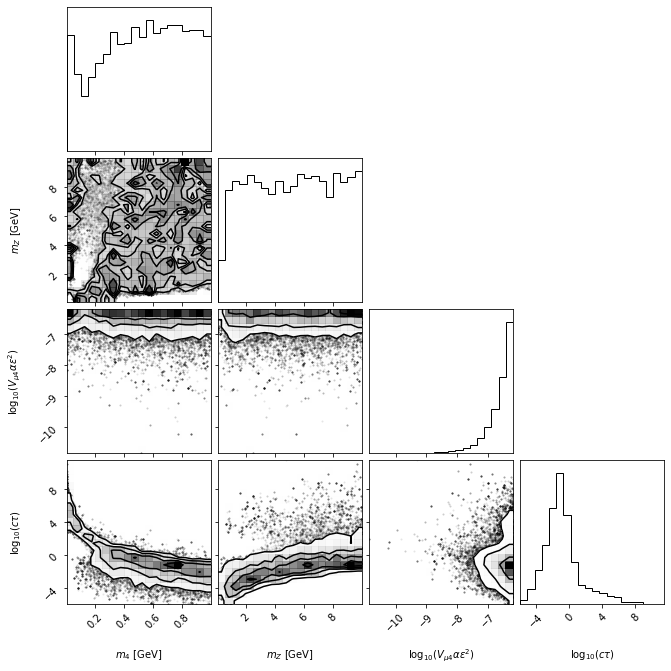

In [98]:
figure = corner.corner(physics_samples, labels=[r'$m_4$ [GeV]',
                                        r'$m_Z$ [GeV]',
                                        r'$\log_{10}(V_{\mu 4}\alpha \epsilon^2)$',
                                        r'$\log_{10}(c\tau$)'])

## Advanced plots

In [ ]:
# samples[:,2] = samples[:,2]*Vmu4
# samples[:,3] = samples[:,3]*alpha_epsilon2
# ctau_fit = ctau_light(samples[:, 0], samples[:, 1], samples[:,2])
# aux_sample = np.concatenate([samples, ctau_fit[...,np.newaxis]], axis=1)
# aux_sample_with_logs = aux_sample
# aux_sample_with_logs[:,2] = np.log10(aux_sample_with_logs[:,2])
aux_sample_with_logs[:,3] = np.log10(aux_sample_with_logs[:,3])
aux_sample_with_logs[:,4] = np.log10(aux_sample_with_logs[:,4])

In [ ]:
figure = corner.corner(samples, labels=[r'$m_4$ [GeV]', r'$m_Z$ [GeV]', r'$\mu$'])

In [ ]:
figure = corner.corner(samples, labels=[r'$m_4$ [GeV]', r'$m_Z$ [GeV]', r'$V_{\mu 4}$', r'$\alpha \epsilon^2$'])
# plt.savefig(save_folder + 'out_mcmc_4pars_16walkers.png', dpi=250)

In [ ]:
figure = corner.corner(aux_sample, labels=[r'$m_4$ [GeV]', r'$m_Z$ [GeV]', r'$V_{\mu 4}$', r'$\alpha \epsilon^2$', r'c$\tau$'])
# plt.savefig(save_folder + 'contour_light_minimal.png', dpi=250)

In [ ]:
plt.hist(np.log10(ctau_fit), bins=50)
plt.xlabel(r'$\log_{10}(c\tau$) [cm]')
plt.savefig(save_folder + 'ctau.png', dpi=250)

In [ ]:
plt.hist(np.log10(samples[:,2]), bins=50)
plt.xlabel(r'$\log_{10}(V_{\mu 4}$)')
plt.savefig(save_folder + 'Vmu4.png', dpi=250)

In [ ]:
plt.hist(np.log10(samples[:,3]), bins=50)
plt.xlabel(r'$\log_{10}(\alpha_{QED}\epsilon^2$)')
plt.savefig(save_folder + 'alpha_epsilon2.png', dpi=250)

In [ ]:
figure = corner.corner(aux_sample_with_logs, labels=[r'$m_4$ [GeV]', r'$m_Z$ [GeV]', r'$\log_{10}(V_{\mu 4})$', r'$\log_{10}(\alpha \epsilon^2)$', r'$\log_{10}(c\tau$)'])
plt.savefig(save_folder + 'contour_light_minimal_logs.png', dpi=250)